In [1]:
import pandas as pd
import numpy as np
import os, random
from matplotlib import pyplot as plt
from scipy.stats import rankdata
from scipy.stats import pearsonr
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

In [2]:
volmeta = pd.read_csv('Data/updatedvolumemetadata.tsv', sep = '\t')

In [3]:
volmeta.head()

,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,enumcron,gbindex,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,loc.ark+=13960=t5p851b8s,"Reid, Stuart J.",NaN,Lord John Russell,1895,NaN,New York;Harper & brothers;1,"Reid, Stuart J. | Lord John Russell",<blank>,27553,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
1,hvd.32044070870779,"Smiles, Samuel,",NaN,Lives of the engineers,1879,NaN,London;J. Murray;1874-1877.,"Smiles, Samuel | Lives of the Engineers",v. 5,27710,...,NaN,NaN,bio | short,NaN,m,NaN,"2 people, mixed together (not one per chapter)",morgan,gutenbiotrimmed,Trimmed
2,mdp.39015005892362,"Cruttwell, Maud.",NaN,Luca Signorelli,1899,NaN,London;G. Bell & sons;1899.,"Cruttwell, Maud | Luca Signorelli",<blank>,27759,...,NaN,NaN,bio,NaN,f,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
3,mdp.39015051108531,"Bettany, George Thomas,",NaN,Life of Charles Darwin,1887,NaN,London;W. Scott;1887.,"Bettany, George Thomas | Life of Charles Darwin",<blank>,28380,...,NaN,NaN,bio,NaN,m,NaN,NaN,morgan,gutenbiotrimmed,Trimmed
4,loc.ark+=13960=t6b27z54n,"Gay, Sydney Howard,",NaN,James Madison,1889,NaN,"Boston;New York;Houghton, Mi","Gay, Sydney Howard | James Madison",<blank>,28992,...,NaN,NaN,bio,NaN,u,NaN,NaN,morgan,gutenbiotrimmed,Trimmed


In [4]:
cleanfiles = [x for x in os.listdir('D:\DH collaborative\OCR\cleannarratives\\')
              if x.endswith('.txt')]
dirtyfiles = [x for x in os.listdir('D:\DH collaborative\OCR\dirtynarratives\\')
               if x.endswith('.txt')]

In [5]:
print("We have " + str(len(cleanfiles)) + " clean chunks, and")
print(str(len(dirtyfiles)), " dirty ones.")

We have 2489 clean chunks, and
2610  dirty ones.


In [6]:
def get_gbindex(filename):
    return filename.split('_')[0]

gbdict = dict()

for filename in cleanfiles:
    gbindex = get_gbindex(filename)
    if gbindex not in gbdict:
        gbdict[gbindex] = []
    gbdict[gbindex].append(filename)

gbset = set(gbdict.keys())

In [7]:
print("We have " + str(len(gbset)) + " separate clean volumes that have been chunked.")

We have 423 separate clean volumes that have been chunked.


In [8]:
ourtitles = volmeta.loc[volmeta['gbindex'].isin(gbset), : ]
ourtitles.shape

(423, 24)

In [9]:
def create_chunkframe(filelist, volmeta):
    
    chunkids = []
    gbindices = []
    
    for filename in filelist:
        chunkids.append(filename.replace('.txt', ''))
        gbindices.append(get_gbindex(filename))
    
    df = pd.DataFrame({'chunkid': chunkids, 'gbindex': gbindices})
    
    chunkmeta = df.merge(volmeta, how = 'inner', on = 'gbindex')
    
    return chunkmeta

In [10]:
cleanmeta = create_chunkframe(cleanfiles, ourtitles)
cleanmeta.set_index('chunkid', inplace = True)
cleanmeta.shape

(2489, 24)

In [11]:
dirtymeta = create_chunkframe(dirtyfiles, ourtitles)
dirtymeta.set_index('chunkid', inplace = True)
dirtymeta.shape

(2610, 24)

In [12]:
clean_rootdir = 'D:\DH collaborative\OCR\cleannarratives\\'

clean_paths = []

for chunk_id in cleanmeta.index:
    clean_paths.append(clean_rootdir + chunk_id + '.txt')

In [13]:
clean_model_chunk_ids = cleanmeta.index

vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_clean_counts = vectorizer.fit_transform(clean_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
clean_wordcounts = pd.DataFrame(sparse_clean_counts.toarray(), index = clean_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
clean_wordcounts.head()

,000,10,100,10th,11,11th,12,12th,13,13th,...,youthful,youths,zeal,zealand,zealous,zealously,zenith,zest,zigzag,zone
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1079_1,0,2,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1079_10,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,0,0
1079_11,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1079_12,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
dirty_rootdir = 'D:\DH collaborative\OCR\dirtynarratives\\'

dirty_paths = []

for chunk_id in dirtymeta.index:
    dirty_paths.append(dirty_rootdir + chunk_id + '.txt')

dirty_model_chunk_ids = dirtymeta.index
    
vectorizer = CountVectorizer(input = 'filename', min_df = .02)
sparse_dirty_counts = vectorizer.fit_transform(dirty_paths) # the vectorizer produces something
                                                               # called a 'sparse matrix'; we need to
                                                               # unpack it
dirty_wordcounts = pd.DataFrame(sparse_dirty_counts.toarray(), index = dirty_model_chunk_ids, 
                            columns = vectorizer.get_feature_names())
dirty_wordcounts.head()

,00,000,01,10,100,101,102,103,104,105,...,ſwore,ſyſtem,ſº,ﬁlled,ﬁnd,ﬁne,ﬁre,ﬁrst,ﬁve,ﬁxed
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,1,0,0,4,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1079_1,0,0,0,3,0,0,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
1079_10,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1079_11,0,0,0,3,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1079_12,0,0,0,2,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,0


In [15]:
clean_rowsums = clean_wordcounts.sum(axis = 'columns')
clean_freqs = clean_wordcounts.divide(clean_rowsums, axis = 'rows')

In [16]:
print(clean_freqs.shape)
clean_freqs.head()

(2489, 17316)


,000,10,100,10th,11,11th,12,12th,13,13th,...,youthful,youths,zeal,zealand,zealous,zealously,zenith,zest,zigzag,zone
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000074,0.000000,0.000074,0.0,...,0.0,0.0,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_1,0.0,0.000158,0.0,0.0,0.000079,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_10,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000158,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_11,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000074,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_12,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000078,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
dirty_rowsums = dirty_wordcounts.sum(axis = 'columns')
dirty_freqs = dirty_wordcounts.divide(dirty_rowsums, axis = 'rows')

In [18]:
print(dirty_freqs.shape)
dirty_freqs.head()

(2610, 20109)


,00,000,01,10,100,101,102,103,104,105,...,ſwore,ſyſtem,ſº,ﬁlled,ﬁnd,ﬁne,ﬁre,ﬁrst,ﬁve,ﬁxed
chunkid,,,,,,,,,,,,,,,,,,,,,
1079_0,0.000077,0.0,0.0,0.000309,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_1,0.000000,0.0,0.0,0.000240,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_10,0.000000,0.0,0.0,0.000078,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000078,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_11,0.000000,0.0,0.0,0.000232,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000077,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1079_12,0.000000,0.0,0.0,0.000154,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000077,0.000231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# First we create five lists of authors, to be held out in different iterations.

selected_authors = list(set(volmeta['author']))
random.shuffle(selected_authors)

fivetestsets = np.array_split(selected_authors, 5)  # this numpy function takes care of the split
testlengths = [len(x) for x in fivetestsets]
testlengths

[114, 114, 113, 113, 113]

In [20]:
# Now we define a function that will return training and testing data (normalized frequencies)
# given a list of authors in a particular test set (any one of the five we just created).

def clean_and_dirty_freqs(atestset, cleanmodelmeta, dirtymodelmeta, clean_freqs, dirty_freqs):
    
    cleantrain = cleanmodelmeta.loc[~cleanmodelmeta['author'].isin(atestset), : ]
    cleantest = cleanmodelmeta.loc[cleanmodelmeta['author'].isin(atestset), : ]
    cleantrain_freqs = clean_freqs.loc[cleantrain.index]
    cleantest_freqs = clean_freqs.loc[cleantest.index]

    dirtytrain = dirtymodelmeta.loc[~dirtymodelmeta['author'].isin(atestset), : ]
    dirtytest = dirtymodelmeta.loc[dirtymodelmeta['author'].isin(atestset), : ]
    dirtytrain_freqs = dirty_freqs.loc[dirtytrain.index]
    dirtytest_freqs = dirty_freqs.loc[dirtytest.index]
    
    return cleantrain, cleantest, cleantrain_freqs, cleantest_freqs, dirtytrain, dirtytest, dirtytrain_freqs, dirtytest_freqs

In [21]:
cleantrain, cleantest, cleantrain_freqs, cleantest_freqs, dirtytrain, dirtytest, dirtytrain_freqs, dirtytest_freqs = clean_and_dirty_freqs(fivetestsets[0],
                                                                                cleanmeta, dirtymeta, 
                                                                                 clean_freqs, dirty_freqs)

print('Clean training set: ', cleantrain.shape)
print('Clean test set: ', cleantest.shape)
print('Hathi training set: ', dirtytrain.shape)
print('Hathi testing set: ', dirtytest.shape)

Clean training set:  (1994, 24)
Clean test set:  (495, 24)
Hathi training set:  (2102, 24)
Hathi testing set:  (508, 24)


In [22]:
def get_doc_freqs(X, y):
    return np.count_nonzero(X, axis=0)  

docfreqs = []
for col in clean_wordcounts.columns:
    docfreqs.append((sum(clean_wordcounts[col] > 0), col))
docfreqs.sort()

1000 20000 22.361101055258885
1000 15000 21.209394246200695
1000 10000 19.94681995804386
1000 5000 18.753796279618747
1000 3000 18.564817812818482
1000 1000 19.36221064095259
1000 500 20.407714838769543
1000 100 23.421805134684696
1000 10 26.581826193856198
1000 1 27.307586159615973
1000 0.1 27.391540878086424
3000 20000 18.789518990833347
3000 15000 18.300517454365337
3000 10000 17.872008338838405
3000 5000 17.587529656141307
3000 3000 17.660338797686386
3000 1000 18.27246877969331
3000 500 18.87719601399835
3000 100 20.618080482406416
3000 10 22.079653979699188
3000 1 22.329954419224894
3000 0.1 22.356984627653162
5000 20000 18.198662654703536
5000 15000 17.900080529411564
5000 10000 17.683128658891132
5000 5000 17.64662876567032
5000 3000 17.827154374220807
5000 1000 18.46084658328292
5000 500 18.909194710758698
5000 100 19.598748178755812
5000 10 19.840970918659885
5000 1 19.868136234668373
5000 0.1 19.870886051599957
7000 20000 18.133395820656627
7000 15000 17.917875667635247
7000

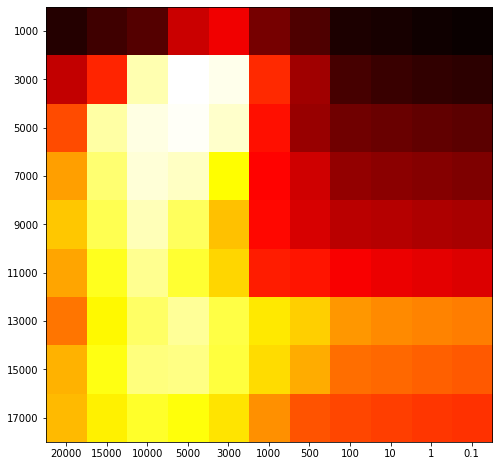

(3000, 5000)
17.154673875014353
1000 20000 22.91381909427329
1000 15000 21.78595447423392
1000 10000 20.562189211415404
1000 5000 19.398100978307895
1000 3000 19.268759262072468
1000 1000 20.345835944011768
1000 500 21.603862813126945
1000 100 25.002375740389397
1000 10 28.262561081000012
1000 1 29.058652740401634
1000 0.1 29.15416828159416
3000 20000 18.837477872509872
3000 15000 18.33542965581158
3000 10000 17.885301669054932
3000 5000 17.61324060812573
3000 3000 17.751760966647097
3000 1000 18.739237506310932
3000 500 19.665548902124392
3000 100 21.82356753106035
3000 10 23.366937964598257
3000 1 23.637281281112795
3000 0.1 23.666492171126315
5000 20000 17.93132806488432
5000 15000 17.57262387228238
5000 10000 17.267969287410285
5000 5000 17.13890335228276
5000 3000 17.240122980429202
5000 1000 17.73265100971143
5000 500 18.117994562134573
5000 100 18.7295610589943
5000 10 18.969615125433705
5000 1 18.998622716291855
5000 0.1 19.00158937594236
7000 20000 18.064314870948934
7000 1500

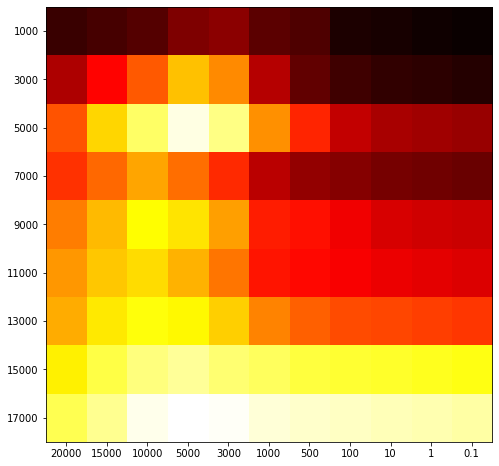

(17000, 5000)
15.567475030913673
1000 20000 20.827918790956275
1000 15000 19.814294606449987
1000 10000 18.68478857134991
1000 5000 17.58202900060809
1000 3000 17.377398189522847
1000 1000 18.45815019814132
1000 500 19.673662870530585
1000 100 22.666362516688604
1000 10 25.30526691511762
1000 1 25.84488879098408
1000 0.1 25.907136257795695
3000 20000 16.941080182533373
3000 15000 16.45288718362786
3000 10000 16.02620640418771
3000 5000 15.879382507513881
3000 3000 16.188398746626373
3000 1000 17.5290229739575
3000 500 18.626280893383047
3000 100 21.16732936561039
3000 10 23.1253718807288
3000 1 23.504772330629606
3000 0.1 23.546145999799602
5000 20000 16.220079522270133
5000 15000 15.910056521136315
5000 10000 15.69161178833276
5000 5000 15.728806826857232
5000 3000 15.989500131688184
5000 1000 16.79992702364304
5000 500 17.319423325397366
5000 100 18.101782467736044
5000 10 18.38877785584722
5000 1 18.42155013748419
5000 0.1 18.424864855191032
7000 20000 16.394746709688807
7000 15000 

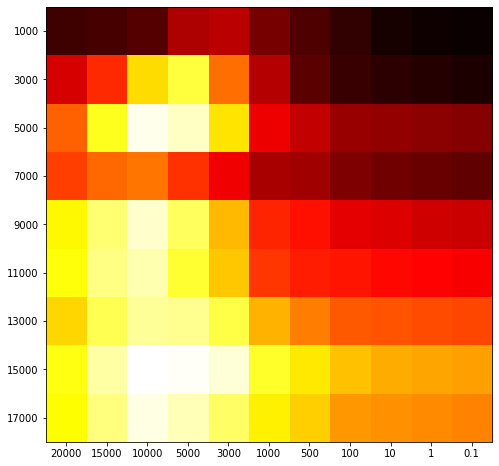

(15000, 10000)
23.88695723508736
1000 20000 23.895012525030094
1000 15000 22.637748099746773
1000 10000 21.15948459498548
1000 5000 19.570332311928098
1000 3000 19.08840937653587
1000 1000 19.471586891642964
1000 500 20.23989898161347
1000 100 22.9611965596073
1000 10 26.893804346470244
1000 1 27.961377147228166
1000 0.1 28.091311757020822
3000 20000 20.05762276999144
3000 15000 19.477614308389953
3000 10000 18.95281480941084
3000 5000 18.620939071165918
3000 3000 18.74724875217877
3000 1000 19.61965619002712
3000 500 20.396796904237757
3000 100 22.29602900235188
3000 10 23.658685468033674
3000 1 23.870707307452598
3000 0.1 23.893132828979496
5000 20000 19.127982704480434
5000 15000 18.768463298834995
5000 10000 18.469131759305192
5000 5000 18.33605054885868
5000 3000 18.450445582638466
5000 1000 18.97332441340044
5000 500 19.357273728529403
5000 100 19.958924731485347
5000 10 20.177317047058416
5000 1 20.20182248717838
5000 0.1 20.204303672944096
7000 20000 19.114784419145963
7000 150

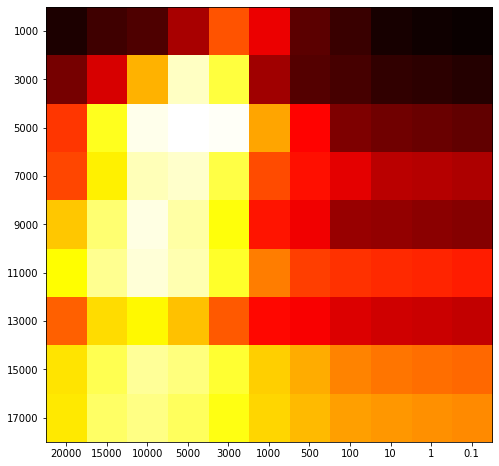

(5000, 5000)
13.718555813544766
1000 20000 21.554056017325316
1000 15000 20.382136794081624
1000 10000 19.020764784411213
1000 5000 17.587276638526635
1000 3000 17.114980694223977
1000 1000 17.169576759819684
1000 500 17.595817363040265
1000 100 18.970573351390414
1000 10 20.479280654920025
1000 1 20.838852746466664
1000 0.1 20.882265513700936
3000 20000 17.387325211289586
3000 15000 16.82566089667383
3000 10000 16.31540811940217
3000 5000 15.94884828192149
3000 3000 15.872646556996234
3000 1000 16.27386021588986
3000 500 16.88164361430507
3000 100 18.958079520837465
3000 10 20.99283830304011
3000 1 21.367932246217688
3000 0.1 21.40906016652131
5000 20000 16.666995643773145
5000 15000 16.311868551703178
5000 10000 15.999022896243645
5000 5000 15.82680955437478
5000 3000 15.858266935906707
5000 1000 16.204762000154567
5000 500 16.502301348860207
5000 100 16.990069103397374
5000 10 17.179866319304388
5000 1 17.201393185360764
5000 0.1 17.20358636522254
7000 20000 16.32456017452364
7000 1

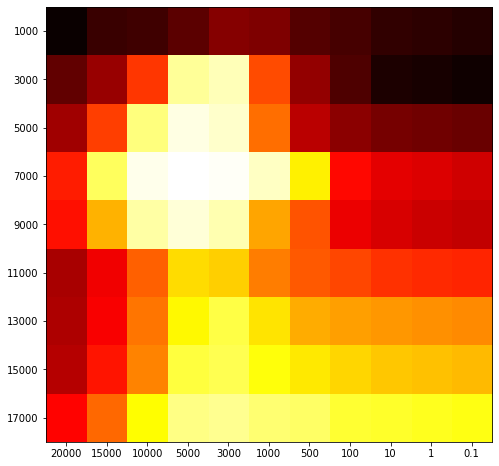

(7000, 5000)
18.993611508767906


In [23]:
clean_chunkids = []
clean_predictions = []

for testset in fivetestsets:
    cleantrain, cleantest, cleantrain_freqs, cleantest_freqs, na1, na2, na3, na4 = clean_and_dirty_freqs(testset,
                                                                                 cleanmeta, dirtymeta, 
                                                                                 clean_freqs, dirty_freqs)
    # Note that I give the dirty sets variable names that begin NA (not applicable)
    # because we're not using them right now 
    
    resultarray = []
    resultlist = []
    paramlist = []

    featureoptions = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000]
    alphaoptions = [20000, 15000, 10000, 5000, 3000, 1000, 500, 100, 10, 1, .1]


    for featurecount in featureoptions:
        docfreqs = []
        for col in cleantrain_freqs.columns:
            docfreqs.append((sum(cleantrain_freqs[col] > 0), col))
        docfreqs.sort()
        features = [x[1] for x in docfreqs[-featurecount : ]] # because sorted in ascending order

        model_features = cleantrain_freqs.loc[ : , features]

        resultrow = []

        for alpha_param in alphaoptions:
            clf = Ridge(alpha = alpha_param)
            group_kfold = GroupKFold(n_splits=10)
            mean_score = 0
            for train_index, test_index in group_kfold.split(model_features, cleantrain['latestcomp'], groups = cleantrain['author']):
                X_train = model_features.iloc[train_index, :]
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = model_features.iloc[test_index, :]
                X_test = scaler.transform(X_test)
                y_train = cleantrain['latestcomp'].iloc[train_index]
                y_test = cleantrain['latestcomp'].iloc[test_index]
                clf.fit(X_train, y_train)
                clean_preds = clf.predict(X_test)
                clean_diffs = clean_preds - y_test
                clean_absolute_diffs = np.abs(clean_diffs)
                fold_mean = clean_absolute_diffs.mean()
                mean_score += fold_mean
            mean_score = mean_score/10
            resultrow.append(mean_score)
            resultlist.append(mean_score)
            paramlist.append((featurecount, alpha_param))
            print(featurecount, alpha_param, mean_score)
        
        resultarray.append(resultrow)
    
    # Let's visualize the grid search for this model pass.
    
    resultarray = np.array(resultarray)
    thearrayshape = resultarray.shape
    resarray = rankdata(resultarray).reshape(thearrayshape)
    
    fig, ax = plt.subplots(figsize=(8,8))

    ax.imshow(resarray, cmap='hot_r', aspect = 'auto')
    plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
    thexlabels = [str(x) for x in alphaoptions]
    plt.xticks(ticks = [x for x in range(len(alphaoptions))], labels = thexlabels)
    plt.show()
    
    # now find best parameters for this model pass
    
    bestrun = resultlist.index(min(resultlist))
    bestparams = paramlist[bestrun]
    print(bestparams)
    
    best_featurecount, best_alpha_param = bestparams
    
    # apply those parameters to create an optimal model

    features = [x[1] for x in docfreqs[-best_featurecount: ]] # negative because sorted ascending
    train_features = cleantrain_freqs.loc[ : , features]
    
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)

    ## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

    bestmodel = Ridge(alpha = best_alpha_param)
    bestmodel.fit(train_features, cleantrain['latestcomp'])

    test_features = cleantest_freqs.loc[ : , features] 
    test_features = scaler.transform(test_features) # Note this is the same scaler we fit
                                                    # to train features; we DON'T fit a new one to the
                                                    # test features. We deliberately blind ourselves to that
                                                    # information.

    these_predictions = bestmodel.predict(test_features)
    clean_predictions.extend(these_predictions)
    clean_chunkids.extend(cleantest.index.tolist())
    
    clean_diffs = these_predictions - cleantest['latestcomp']
    clean_absolute_diffs = np.abs(clean_diffs)
    mean_diff = clean_absolute_diffs.mean()
    print(mean_diff)

In [24]:
print(cleanmeta.shape)
cleanmeta = cleanmeta.loc[clean_chunkids, : ]
cleanmeta.reset_index(inplace = True)
cleanmeta.shape
cleanmeta

(2489, 24)


,chunkid,gbindex,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,1079_0,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
1,1079_1,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
2,1079_10,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
3,1079_11,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
4,1079_12,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
5,1079_2,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
6,1079_3,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
7,1079_4,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
8,1079_5,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
9,1079_6,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed


In [25]:
clean_diffs = clean_predictions - cleanmeta['latestcomp']
clean_absolute_diffs = np.abs(clean_diffs)
mean_diff = clean_absolute_diffs.mean()
print(clean_diffs.mean())
print(mean_diff)

0.9483559662519617
17.29775208340161


1000 20000 21.660465877212232
1000 15000 20.667660768034644
1000 10000 19.641019585528458
1000 5000 18.622960757696838
1000 3000 18.40177253850233
1000 1000 18.810270263937774
1000 500 19.46945231058252
1000 100 21.687440019846317
1000 10 23.887315863928354
1000 1 24.36590608927473
1000 0.1 24.42094019080053
3000 20000 18.221251731482216
3000 15000 17.77072676277988
3000 10000 17.380969264623246
3000 5000 17.215523330753083
3000 3000 17.33683835975793
3000 1000 17.96769820791598
3000 500 18.556600240987986
3000 100 20.30616561503732
3000 10 21.98785458940302
3000 1 22.305020270657465
3000 0.1 22.34024020041813
5000 20000 17.390207326984946
5000 15000 17.115832858847774
5000 10000 16.9012725174066
5000 5000 16.858374849836192
5000 3000 16.979651340842928
5000 1000 17.550479504497567
5000 500 17.969311640340607
5000 100 18.653006642792484
5000 10 18.926808931382155
5000 1 18.958783033310986
5000 0.1 18.962024840006926
7000 20000 16.774096014163057
7000 15000 16.58780071251849
7000 10000 

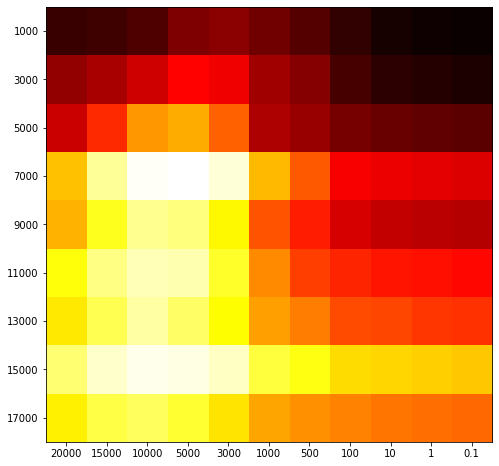

(7000, 5000)
14.734621867387997
1000 20000 22.281363201112548
1000 15000 21.235839569264364
1000 10000 20.111295892931793
1000 5000 18.900368974412583
1000 3000 18.545937249738422
1000 1000 18.987632499035115
1000 500 19.773692416307377
1000 100 22.25053593890792
1000 10 24.879828807781955
1000 1 25.47593345499171
1000 0.1 25.54459998410166
3000 20000 18.369765677509527
3000 15000 17.82454484777222
3000 10000 17.31619069730121
3000 5000 16.983421778830028
3000 3000 17.03400164545416
3000 1000 17.742904651678916
3000 500 18.522770679607113
3000 100 21.005338351442383
3000 10 23.366175303213083
3000 1 23.82158740583651
3000 0.1 23.871749310445516
5000 20000 17.360580600489556
5000 15000 17.00807759553991
5000 10000 16.68612514857645
5000 5000 16.51874012677018
5000 3000 16.608033845421918
5000 1000 17.154111496667063
5000 500 17.593559359664177
5000 100 18.402902616645385
5000 10 18.772669276858466
5000 1 18.818080096250075
5000 0.1 18.822717282888398
7000 20000 16.909799373484365
7000 1

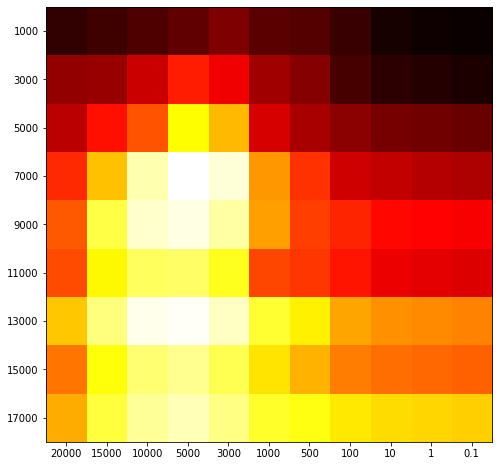

(7000, 5000)
14.123525086506922
1000 20000 19.847956683700083
1000 15000 18.924313899642467
1000 10000 17.970611957651183
1000 5000 17.030007469394416
1000 3000 16.773149848777507
1000 1000 17.1405924054561
1000 500 17.751391011368405
1000 100 19.722697629577038
1000 10 21.646413947465923
1000 1 22.03446476937291
1000 0.1 22.07835559258801
3000 20000 16.38982256660656
3000 15000 15.883602138064356
3000 10000 15.429001723578605
3000 5000 15.1283114236686
3000 3000 15.225702351813982
3000 1000 16.061322029760696
3000 500 16.961546870459376
3000 100 19.62193216373472
3000 10 22.337818597138252
3000 1 22.893027808246174
3000 0.1 22.955408412029193
5000 20000 15.557237205996623
5000 15000 15.22136862131038
5000 10000 14.936958396729612
5000 5000 14.845259787105652
5000 3000 14.996155493619835
5000 1000 15.607590121703058
5000 500 16.061108526924414
5000 100 16.816306853841304
5000 10 17.12787085966445
5000 1 17.165193259866154
5000 0.1 17.16902603798161
7000 20000 14.979894261189227
7000 15

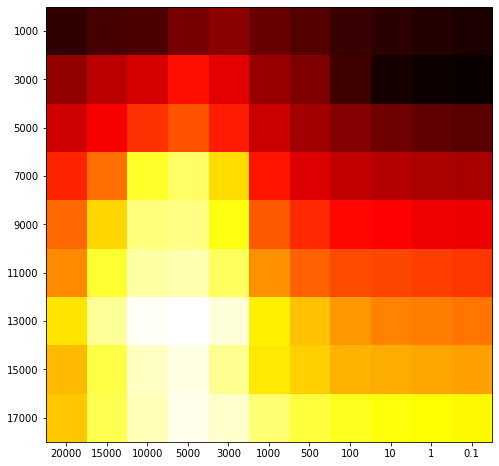

(13000, 5000)
22.796458997215264
1000 20000 22.625612513248463
1000 15000 21.439162219598035
1000 10000 20.150935170966697
1000 5000 18.833773449656935
1000 3000 18.51564788134771
1000 1000 18.848062306108034
1000 500 19.542061708045146
1000 100 22.00464885357532
1000 10 24.926131566282045
1000 1 25.609634231107634
1000 0.1 25.689987772174778
3000 20000 18.77957799707268
3000 15000 18.233405431790437
3000 10000 17.72445651563023
3000 5000 17.423598770405896
3000 3000 17.527830716020002
3000 1000 18.197343873996612
3000 500 18.83564087411397
3000 100 20.536458680591394
3000 10 21.980280552649678
3000 1 22.233262761991814
3000 0.1 22.260691238659014
5000 20000 17.767902401021036
5000 15000 17.400373155637418
5000 10000 17.087341219181777
5000 5000 16.949143430516365
5000 3000 17.062967414470048
5000 1000 17.66870979971262
5000 500 18.141380544056695
5000 100 18.95387697465312
5000 10 19.276990311787795
5000 1 19.315990001251365
5000 0.1 19.31995929816941
7000 20000 17.267688378819763
700

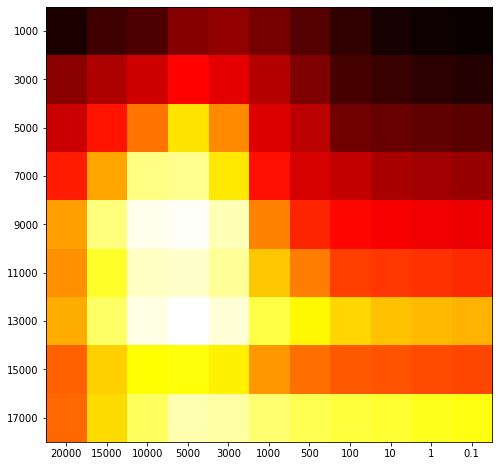

(13000, 5000)
13.337775070210572
1000 20000 21.26060492638604
1000 15000 20.222497304255338
1000 10000 19.071300192802898
1000 5000 17.852486105538457
1000 3000 17.442673100099277
1000 1000 17.496167069450852
1000 500 17.9586402109365
1000 100 19.685034183160873
1000 10 21.6767558250505
1000 1 22.099137345507426
1000 0.1 22.1467792290436
3000 20000 17.26445628991375
3000 15000 16.632652468357257
3000 10000 16.012230312913022
3000 5000 15.494984715893741
3000 3000 15.415772974029005
3000 1000 15.87208027576276
3000 500 16.538246866955117
3000 100 18.567822945766633
3000 10 20.548519113610524
3000 1 20.9436951369187
3000 0.1 20.988001128907378
5000 20000 16.36770719441302
5000 15000 15.920144628299202
5000 10000 15.528132911957064
5000 5000 15.26369724347137
5000 3000 15.287838989346005
5000 1000 15.74849443089409
5000 500 16.130219914673326
5000 100 16.793845957919558
5000 10 17.052337156970808
5000 1 17.083075824323643
5000 0.1 17.086193528810757
7000 20000 15.82068731467279
7000 15000

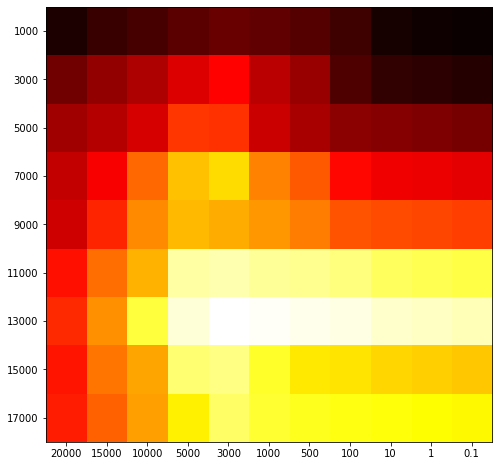

(13000, 3000)
16.79116708347433


In [26]:
dirty_chunkids = []
dirty_predictions = []

for testset in fivetestsets:
    dirtytrain, dirtytest, dirtytrain_freqs, dirtytest_freqs, na1, na2, na3, na4 = clean_and_dirty_freqs(testset,
                                                                                 dirtymeta, dirtymeta, 
                                                                                 dirty_freqs, dirty_freqs)
    # Note that I give the dirty sets variable names that begin NA (not applicable)
    # because we're not using them right now 
    
    resultarray = []
    resultlist = []
    paramlist = []

    featureoptions = [1000, 3000, 5000, 7000, 9000, 11000, 13000, 15000, 17000]
    alphaoptions = [20000, 15000, 10000, 5000, 3000, 1000, 500, 100, 10, 1, .1]


    for featurecount in featureoptions:
        docfreqs = []
        for col in dirtytrain_freqs.columns:
            docfreqs.append((sum(dirtytrain_freqs[col] > 0), col))
        docfreqs.sort()
        features = [x[1] for x in docfreqs[-featurecount : ]] # because sorted in ascending order

        model_features = dirtytrain_freqs.loc[ : , features]

        resultrow = []

        for alpha_param in alphaoptions:
            clf = Ridge(alpha = alpha_param)
            group_kfold = GroupKFold(n_splits=10)
            mean_score = 0
            for train_index, test_index in group_kfold.split(model_features, dirtytrain['latestcomp'], groups = dirtytrain['author']):
                X_train = model_features.iloc[train_index, :]
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = model_features.iloc[test_index, :]
                X_test = scaler.transform(X_test)
                y_train = dirtytrain['latestcomp'].iloc[train_index]
                y_test = dirtytrain['latestcomp'].iloc[test_index]
                clf.fit(X_train, y_train)
                dirty_preds = clf.predict(X_test)
                dirty_diffs = dirty_preds - y_test
                dirty_absolute_diffs = np.abs(dirty_diffs)
                fold_mean = dirty_absolute_diffs.mean()
                mean_score += fold_mean
            mean_score = mean_score/10
            resultrow.append(mean_score)
            resultlist.append(mean_score)
            paramlist.append((featurecount, alpha_param))
            print(featurecount, alpha_param, mean_score)
        
        resultarray.append(resultrow)
    
    # Let's visualize the grid search for this model pass.
    
    resultarray = np.array(resultarray)
    thearrayshape = resultarray.shape
    resarray = rankdata(resultarray).reshape(thearrayshape)
    
    fig, ax = plt.subplots(figsize=(8,8))

    ax.imshow(resarray, cmap='hot_r', aspect = 'auto')
    plt.yticks(ticks = [x for x in range(len(featureoptions))], labels = featureoptions)
    thexlabels = [str(x) for x in alphaoptions]
    plt.xticks(ticks = [x for x in range(len(alphaoptions))], labels = thexlabels)
    plt.show()
    
    # now find best parameters for this model pass
    
    bestrun = resultlist.index(min(resultlist))
    bestparams = paramlist[bestrun]
    print(bestparams)
    
    best_featurecount, best_alpha_param = bestparams
    
    # apply those parameters to create an optimal model

    features = [x[1] for x in docfreqs[-best_featurecount: ]] # negative because sorted ascending
    train_features = dirtytrain_freqs.loc[ : , features]
    
    scaler = StandardScaler()
    train_features = scaler.fit_transform(train_features)

    ## NOW APPLY THE SAME SCALER AND MODEL TO TEST SET

    bestmodel = Ridge(alpha = best_alpha_param)
    bestmodel.fit(train_features, dirtytrain['latestcomp'])

    test_features = dirtytest_freqs.loc[ : , features] 
    test_features = scaler.transform(test_features) # Note this is the same scaler we fit
                                                    # to train features; we DON'T fit a new one to the
                                                    # test features. We deliberately blind ourselves to that
                                                    # information.

    these_predictions = bestmodel.predict(test_features)
    dirty_predictions.extend(these_predictions)
    dirty_chunkids.extend(dirtytest.index.tolist())
    
    dirty_diffs = these_predictions - dirtytest['latestcomp']
    dirty_absolute_diffs = np.abs(dirty_diffs)
    mean_diff = dirty_absolute_diffs.mean()
    print(mean_diff)

In [27]:
print(dirtymeta.shape)
dirtymeta = dirtymeta.loc[dirty_chunkids, : ]
dirtymeta.reset_index(inplace = True)
dirtymeta.shape
dirtymeta

(2610, 24)


,chunkid,gbindex,docid,author,authordate,title,latestcomp,hathidate,imprint,gutenstring,...,contents,instances,genre,audience,authgender,multiplehtids,comments,coder,Folder,Trimmed
0,1079_0,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
1,1079_1,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
2,1079_10,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
3,1079_11,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
4,1079_12,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
5,1079_13,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
6,1079_14,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
7,1079_2,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
8,1079_3,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed
9,1079_4,1079,ien.35556006977896,"Laurence, Sterne",1713-1768,"The life and opinions of Tristram Shandy, gent...",1768,1787.0,NaN,NaN,...,NaN,NaN,fic,NaN,m,n,NaN,m,18cgutenbergtrimmed,Trimmed


In [28]:
dirty_diffs = dirty_predictions - dirtymeta['latestcomp']
dirty_absolute_diffs = np.abs(dirty_diffs)
mean_diff = dirty_absolute_diffs.mean()
print(dirty_diffs.mean())
print(mean_diff)

0.5122933082446054
15.837820959953307


In [29]:
clean_gbi = [get_gbindex(x) for x in cleanmeta['chunkid']]
clean_df = pd.DataFrame({'chunkid': list(cleanmeta['chunkid']),
                         'gbindex': clean_gbi, 'clean_diffs': clean_diffs, 'clean_abs_diffs': clean_absolute_diffs})
print(clean_df.shape)
clean_df.head()

(2489, 4)


,chunkid,gbindex,clean_diffs,clean_abs_diffs
0,1079_0,1079,29.538016,29.538016
1,1079_1,1079,33.910991,33.910991
2,1079_10,1079,57.069445,57.069445
3,1079_11,1079,46.377926,46.377926
4,1079_12,1079,47.072466,47.072466


In [30]:
dirty_gbi = [get_gbindex(x) for x in dirtymeta['chunkid']]
dirty_df = pd.DataFrame({'chunkid': list(dirtymeta['chunkid']),
                         'gbindex': dirty_gbi, 'dirty_diffs': dirty_diffs, 'dirty_abs_diffs': dirty_absolute_diffs})
print(dirty_df.shape)
dirty_df.head()

(2610, 4)


,chunkid,gbindex,dirty_diffs,dirty_abs_diffs
0,1079_0,1079,5.794554,5.794554
1,1079_1,1079,1.367224,1.367224
2,1079_10,1079,18.586284,18.586284
3,1079_11,1079,27.456068,27.456068
4,1079_12,1079,7.836805,7.836805


In [31]:
meandf = clean_df.groupby('gbindex').mean()
print(meandf.shape)
meandf.head()

# here the clean_abs_diffs is not the absolute value of clean diffs
# since different chunks of a text could be predicted to different directions

(423, 2)


,clean_diffs,clean_abs_diffs
gbindex,,
1079,43.913756,43.913756
11030,7.390084,7.390084
12259,71.291573,71.291573
12669,12.183183,12.183183
15042,-6.595968,6.595968


In [32]:
dirty_df = dirty_df.merge(meandf, on = 'gbindex').set_index('chunkid')
dirty_df['diffs_divergence'] = dirty_df['dirty_diffs'] - dirty_df['clean_diffs']
dirty_df['divergence_of_abs_diffs'] = dirty_df['dirty_abs_diffs'] - dirty_df['clean_abs_diffs']
print(dirty_df.shape)
dirty_df.head()

(2610, 7)


,gbindex,dirty_diffs,dirty_abs_diffs,clean_diffs,clean_abs_diffs,diffs_divergence,divergence_of_abs_diffs
chunkid,,,,,,,
1079_0,1079,5.794554,5.794554,43.913756,43.913756,-38.119202,-38.119202
1079_1,1079,1.367224,1.367224,43.913756,43.913756,-42.546532,-42.546532
1079_10,1079,18.586284,18.586284,43.913756,43.913756,-25.327472,-25.327472
1079_11,1079,27.456068,27.456068,43.913756,43.913756,-16.457688,-16.457688
1079_12,1079,7.836805,7.836805,43.913756,43.913756,-36.076951,-36.076951


In [33]:
print(dirty_df['diffs_divergence'].mean())
print(dirty_df['divergence_of_abs_diffs'].mean())

-0.11386168122962191
-1.5579255162878416


In [34]:
error0 = pd.read_csv('Data/mismatch/hathinocorrerrs0.tsv', sep = '\t')
error1 = pd.read_csv('Data/mismatch/hathinocorrerrs1.tsv', sep = '\t')
error2 = pd.read_csv('Data/mismatch/hathinocorrerrs2.tsv', sep = '\t')
error3 = pd.read_csv('Data/mismatch/hathinocorrerrs3.tsv', sep = '\t')
error4 = pd.read_csv('Data/mismatch/hathinocorrerrs4.tsv', sep = '\t')
chunkerrors = pd.concat([error0, error1, error2, error3, error4], ignore_index = True)
chunkerrors.columns

Index(['chunkid', 'passagefails', 'worderrors'], dtype='object')

In [35]:
chunkerrors = chunkerrors.merge(dirty_df, on = 'chunkid')
print(chunkerrors.shape)
chunkerrors.head()

(2624, 10)


,chunkid,passagefails,worderrors,gbindex,dirty_diffs,dirty_abs_diffs,clean_diffs,clean_abs_diffs,diffs_divergence,divergence_of_abs_diffs
0,36958_0,0.01900,0.01423,36958,3.431465,3.431465,1.441956,3.300937,1.989509,0.130528
1,36958_1,0.00392,0.01280,36958,9.561981,9.561981,1.441956,3.300937,8.120025,6.261044
2,36958_2,0.00788,0.01131,36958,-2.878382,2.878382,1.441956,3.300937,-4.320338,-0.422555
3,36958_3,0.01311,0.01050,36958,-1.058364,1.058364,1.441956,3.300937,-2.500320,-2.242573
4,49154_0,0.25348,0.00373,49154,5.408201,5.408201,-11.294641,12.880873,16.702842,-7.472672


In [36]:
print(pearsonr(chunkerrors['passagefails'], chunkerrors['divergence_of_abs_diffs']))
print(pearsonr(chunkerrors['worderrors'], chunkerrors['divergence_of_abs_diffs']))
print(pearsonr(chunkerrors['passagefails'], chunkerrors['diffs_divergence']))
print(pearsonr(chunkerrors['worderrors'], chunkerrors['diffs_divergence']))

(-0.14828505179382817, 2.266577404524926e-14)
(-0.18588195958383222, 7.913122767887218e-22)
(-0.11158685424129841, 9.971147548833694e-09)
(-0.24387625877148844, 7.779892467845156e-37)


<b>Results:</b><br>
1. The sheer amount of difference is weakly and negatively correlated with both paratexts and OCR errors. It should be also noted that, the mean absolute difference of dirty chunks are slightly smaller than that of clean chunks (15.84 years vs 17.30 years, see chunks 25 and 28). <br>
2. The amount of difference between predictions (the absolute value of difference) is also weakly and negatively correlated with both paratexts and OCR errors.  It should be also noted that, the absolute value of difference of dirty chunks are slightly smaller than that of clean chunks (0.51 years later vs 0.95 years, see chunks 25 and 28).

In [37]:
print(pearsonr(chunkerrors['passagefails'], np.abs(chunkerrors['divergence_of_abs_diffs'])))
print(pearsonr(chunkerrors['worderrors'], np.abs(chunkerrors['divergence_of_abs_diffs'])))
print(pearsonr(chunkerrors['passagefails'], np.abs(chunkerrors['diffs_divergence'])))
print(pearsonr(chunkerrors['worderrors'], np.abs(chunkerrors['diffs_divergence'])))

(0.3491669454009513, 4.198904446002544e-76)
(0.19073342201810994, 6.439284527991595e-23)
(0.3783755007320198, 4.364100832582692e-90)
(0.23989704489704683, 1.1539479504614507e-35)


3. The abosolute value of sheer amount of difference is positively correlated with both OCR errors and paratext. <br>
4. The amount of difference between predictions (the absolute value of difference) is positively correlated with both OCR errors and paratext. <br>
Combining results 12 and 34, it can be concluded that: the dirty volumes with more OCR errors and paratexts predict the publication year more accurately (the lead of it over the clean texts are enlarged), and they tend to predict the publication year to an earlier date.

In [38]:
print(pearsonr(chunkerrors['diffs_divergence'], chunkerrors['divergence_of_abs_diffs']))
print(pearsonr(chunkerrors['passagefails'], chunkerrors['worderrors']))

(0.1935070945424259, 1.4881083354583552e-23)
(0.09675897408338284, 6.842857861845955e-07)


5.  The sheer amount of difference and the direction of change also has a weak and significant postive correlation, which suggests that the more accurate predictions with dirty texts tend to assign the books to an earlier date (i.e., the dirty texts are particularly good at predicting earlier books). <i> This could be an interesting result</i>. <br>
6. The paratext and OCR error has a weak and significant positive correlation, which suggests weak collinearity.

In [39]:
y = chunkerrors['divergence_of_abs_diffs']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

D:\Softwares\Anaconda\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


                               OLS Regression Results                              
Dep. Variable:     divergence_of_abs_diffs   R-squared:                       0.052
Model:                                 OLS   Adj. R-squared:                  0.051
Method:                      Least Squares   F-statistic:                     71.43
Date:                     Sat, 03 Jul 2021   Prob (F-statistic):           6.21e-31
Time:                             22:37:27   Log-Likelihood:                -9841.4
No. Observations:                     2624   AIC:                         1.969e+04
Df Residuals:                         2621   BIC:                         1.971e+04
Df Model:                                2                                         
Covariance Type:                 nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [40]:
y = chunkerrors['diffs_divergence']
X = sm.add_constant(chunkerrors.loc[ : , ['passagefails', 'worderrors']])

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:       diffs_divergence   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     94.55
Date:                Sat, 03 Jul 2021   Prob (F-statistic):           2.25e-40
Time:                        22:37:27   Log-Likelihood:                -10256.
No. Observations:                2624   AIC:                         2.052e+04
Df Residuals:                    2621   BIC:                         2.054e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2141      0.291      7.612   

7. From OLS, we can see that both direction and significance of the correlations hold true: the sheer amount of difference is significantly  negatively correlated with both paratexts and OCR errors, and the amount of difference between predictions (the absolute value of difference) is also significantly  negatively correlated with both paratexts and OCR errors.

Overall, the results show that: the dirty texts predict the publicaton year more accurately than the clean texts, and that the dirty texts tend to predict the texts to an earlier date than the clean texts. These relations are more significant when the dirty texts have more OCR errors and when they contain more paratexts.<br>
It can be concluded that, the dirty texts are particularly good at predicting earlier books, a plausible explanation of which is that the dirty version of the earlier works contain some incorrectly-recognized words which are unique in these early texts, allowing the dirty version to "cheat" about the publication year. This is more significant when the texts contain more paratexts and OCR errors.